# Heartbeat Sounds - Kaggle Competition

This dataset was originally for a Machine/Deep learning challenge to classify heartbeat
sounds. The data was gathered from two sources: (A), and (B).


(a) From the general public via the iStethoscope Pro iPhone app.

(b) From a clinical trial in hospitals using the digital stethoscope DigiScope.


<u>**We are tasked with two challenges:**</u>

(a) **Heart Sound Segmentation:** locating S1 (lub) and S2 (dub) sounds within audio data.

(b) **Heart Sound Classification:** classifying audio into one of four categories.

## Importing needed libraries

In [ ]:
!pip install pytorch_lightning
!pip install comet_ml

In [ ]:
import os
import torchaudio
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
#from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
from math import isnan
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pytorch_lightning as pl
import torchmetrics
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# base = "/content/drive/MyDrive/Pattern/heartbeat-sounds/"
base = ""
set_a = base + "set_a/"
set_b = base + "set_b/"
src = [set_a+'/**', set_b+'/**']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
with_noise = True

In [ ]:
import warnings
warnings.filterwarnings("ignore", ".*.*")

## Introduction

### What is audio data?


An audio signal is the vibration generated when sound passes through air.  The analog sound received from a microphone is converted to a digital formal by sampling it at consistent time intervals. The number of audio data points recorded every second is called the sample rate.


The higher the sample rate, the higher the quality of the sound.

### Spectrogram

A spectrogram maps the frequency to time of an audio file. It allows the visualization of audio data by frequency in an image format (grayscale or RGB).

A spectrogram image shows the different features the signal produces in a color pattern. 

Our neural network whether convolutional (CNN) or a multi-layer perceptron feed forward neural network (FFN, MLP) will treat the color patterns in the spectrogram as features for the model.

In our project, we will use the PyTorch torchaudio.transforms function to transform the waveform to a spectrogram image format.


## Data Exploratory Analysis

In [ ]:
# Load data
# Read csv and drop unlabeled data
d_a = pd.read_csv(base+'set_a.csv')
d_b = pd.read_csv(base+'set_b.csv')
d_a = d_a[pd.notnull(d_a['label'])]
d_b = d_b[pd.notnull(d_b['label'])]
d = pd.concat([d_a, d_b])
# shuffle data
d = d.sample(frac = 1)
d = d.reset_index(drop=True)
d["fname"] = d["fname"].apply(lambda x: x.replace("Btraining_", ""))
d = d.fillna('')
for i in range(len(d)):
    if d["dataset"].iloc[i] == "b" and d["sublabel"].iloc[i] == '':
        d["fname"].iloc[i] = d["fname"].iloc[i].replace("normal_", "normal__")
        d["fname"].iloc[i] = d["fname"].iloc[i].replace("murmur_", "murmur__")
        d["fname"].iloc[i] = d["fname"].iloc[i].replace("extrastole_", "extrastole__")
d = d.sample(frac = 1)
d = d.reset_index(drop=True)
d

,dataset,fname,label,sublabel
0,b,set_b/normal__177_1307989650056_D1.wav,normal,
1,b,set_b/murmur__171_1307971016233_D.wav,murmur,
2,b,set_b/normal_noisynormal_137_1306764999211_D1.wav,normal,noisynormal
3,b,set_b/normal_noisynormal_155_1306935902813_C.wav,normal,noisynormal
4,b,set_b/normal__172_1307971284351_B1.wav,normal,
...,...,...,...,...
580,b,set_b/normal_noisynormal_123_1306331925797_B.wav,normal,noisynormal
581,b,set_b/murmur__196_1308141034858_B.wav,murmur,
582,b,set_b/normal_noisynormal_141_1306520154450_C1.wav,normal,noisynormal
583,b,set_b/normal__220_1308250132896_D.wav,normal,


In [ ]:
d['label'].unique()

array(['normal', 'murmur', 'extrastole', 'artifact', 'extrahls'],
      dtype=object)

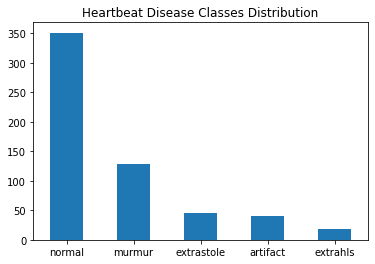

In [ ]:
d.label.value_counts().plot(kind='bar',
                            title='Heartbeat Disease Classes Distribution')
plt.xticks(rotation = 0)
plt.show()

### Signal Denoising 

Using Wavelet transform, we wanted to denoise our audio data. The following is an example taken from in built ecg data from skimage:

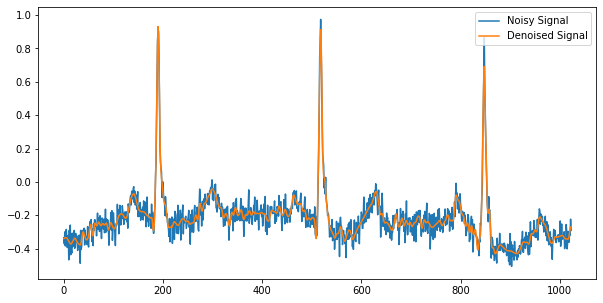

In [ ]:
import pywt
from skimage.restoration import denoise_wavelet

# In-built ecg data is read
x = pywt.data.ecg().astype(float)/256  

sigma = 0.05  # Noise variance

x_noisy = x + sigma * np.random.randn(x.size)   # Adding noise to signal

# Wavelet denoising
x_denoise = denoise_wavelet(x_noisy, method='BayesShrink', 
                            mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')

plt.figure(figsize=(10, 5))
plt.plot(x_noisy, label='Noisy Signal')
plt.plot(x_denoise, label = "Denoised Signal")
plt.legend()
plt.show()

We try the ``` denoise_wavelet ``` function on our data:

selected Audio file with index 203
4000
Original


Denoised


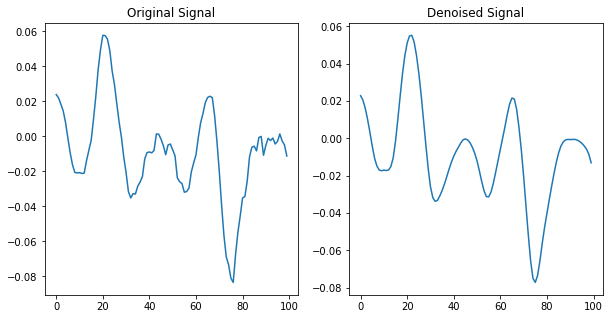

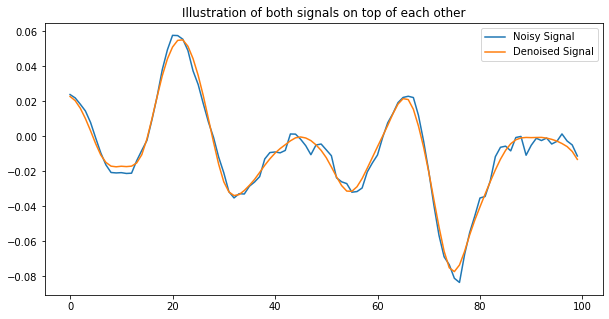

In [ ]:
from scipy.io import wavfile
import random

from IPython.display import Audio, display


selected_idx = random.randint(0,d.shape[0])
print(f"selected Audio file with index {selected_idx}")
start = 5400
end = 5500


signal_path = base+d.iloc[selected_idx]['fname']

fs, audio_file = wavfile.read(signal_path)
print(fs)

# Normalizing values
audio_file  =  audio_file/ np.max(audio_file)

audio_file_denoise = denoise_wavelet(audio_file, method='VisuShrink',
                                     mode='soft', wavelet_levels=3, 
                                     wavelet='sym8', rescale_sigma='True')


print("Original")
display(Audio(audio_file, rate=fs, autoplay=False))
print("Denoised")
display(Audio(audio_file_denoise, rate=fs, autoplay=False))


fig, ax = plt.subplots(1, 2,figsize=(10,5))
ax[0].plot(audio_file[start:end])
ax[0].title.set_text('Original Signal')

ax[1].plot(audio_file_denoise[start:end])
ax[1].title.set_text('Denoised Signal')
plt.show()

print()
plt.figure(figsize=(10, 5))
plt.plot(audio_file[start:end], label='Noisy Signal')
plt.plot(audio_file_denoise[start:end], label = "Denoised Signal")
plt.legend()
plt.title("Illustration of both signals on top of each other")
plt.show()

### Principal Component Analysis (PCA)

As well, to reduce the dimensionality of our audio data, we tried applying PCA to the audio files.


In [ ]:
from sklearn.decomposition import PCA


selected_idx = random.randint(0,d.shape[0])
print(f"selected Audio file with index {selected_idx}")
start = 5400
end = 5500

signal_path = base+d.iloc[selected_idx]['fname']

fs, audio_file = wavfile.read(signal_path)
print(fs)

# Normalizing values
audio_file  =  audio_file/ np.max(audio_file)

N = 1000
pca = PCA(N)
scales = np.arange(1, N+1)

wavelet=[]

coeff1, freqs1 = pywt.cwt(audio_file, scales, 'morl')

adj = pca.fit_transform(coeff1)

print(adj.shape)
wavelet = adj
wavelet=np.array(wavelet)
wavelet = wavelet.flatten()

print(wavelet.shape)

plt.figure(figsize=(20, 10))
plt.plot(wavelet, label='Wavelet After PCA')

selected Audio file with index 552
44100


In [ ]:
print("Original")
display(Audio(wavelet, rate=fs, autoplay=False))

plt.figure(figsize=(20, 10), dpi=100)
plt.plot(wavelet[600:700], label='Wavelet After PCA')

In [ ]:
print("Denoised")
display(Audio(adj, rate=fs, autoplay=False))

plt.figure(figsize=(20, 10))
plt.plot(wavelet[500:550], label='Wavelet After PCA')
plt.show()

### Data Reorganization:

<u>For the first task,</u> the Heart Sound Segmentation, we will split each audio file of setA into multiple cycles of lub and dub. 

Our final .csv file's columns will look like (where the final two columns are two labels):
```
 [ audio_file_cropped_cycle_i location_S1 location_S2 ]

```

It is thus expected that our neural net will have one input and two outputs.

<br>

<u>For the second task,</u> the Heart Sound Classification, we will combine files of setA and setB into one file. We will remove unlabeled data as well as "artifact" labeled data. **Our** categories will be one of: 
```
 [ normal, murmur, extrahls, extrasystole]

```




## Data Splitting and Reorganization

Here, we create .csv files that split our data into training, testing, and validation sets.



### For the Segmentation Task:


#### Reading Timing Csv

In [ ]:
data = pd.read_csv(base+'set_a_timing_fixed.csv')

data.shape

# We have 21 different audio files
print(f"We have a total of {data['fname'].unique().shape[0]} \
Audio Files with Sampling Freuqncy of 44100\n")

data['fname'].unique()

We have a total of 21 Audio Files with Sampling Freuqncy of 44100



array(['set_a/normal__201102081321.wav', 'set_a/normal__201102260502.wav',
       'set_a/normal__201103090635.wav', 'set_a/normal__201103140132.wav',
       'set_a/normal__201103140822.wav', 'set_a/normal__201103151912.wav',
       'set_a/normal__201103221214.wav', 'set_a/normal__201104141251.wav',
       'set_a/normal__201105011626.wav', 'set_a/normal__201105021654.wav',
       'set_a/normal__201105021804.wav', 'set_a/normal__201105151450.wav',
       'set_a/normal__201106111136.wav', 'set_a/normal__201106141148.wav',
       'set_a/normal__201106210943.wav', 'set_a/normal__201106221418.wav',
       'set_a/normal__201106221450.wav', 'set_a/normal__201108011112.wav',
       'set_a/normal__201108011114.wav', 'set_a/normal__201108011115.wav',
       'set_a/normal__201108011118.wav'], dtype=object)

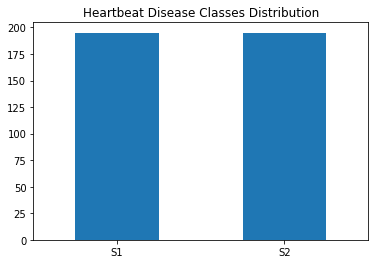

In [ ]:
data['sound'].value_counts().plot(kind='bar',
                            title='Heartbeat Disease Classes Distribution')
plt.xticks(rotation = 0)
plt.show()

#### Grouping Dataset with respect to the audio files

In [ ]:
df2 = data.groupby('fname')['location'].apply(list).reset_index(name="s1_s2_loc")
df2.iloc[0]

fname                           set_a/normal__201102081321.wav
s1_s2_loc    [10021, 20759, 35075, 47244, 62992, 73729, 887...
Name: 0, dtype: object

#### Splitting audio files into cycles

In [ ]:
segmented_samples = {}

In [ ]:
guard_band = 400
max_clip_length = 0

after_last_dub_rand_range = 3000

for index, row in df2.iterrows():

    print(f"Audio File:{row['fname']}")
    fname = base + row['fname']
    
    segmented_samples[fname] = {}
    no_of_cycles = len(row['s1_s2_loc']) // 2

    print(f"Total Number of Cycles {no_of_cycles}")

    sample, sr = torchaudio.load(fname)

     # even S1
    s1_locations = row['s1_s2_loc'][::2]

    # odd S2
    s2_locations = row['s1_s2_loc'][1::2]

    # for each file there exists specific number of samples
    # we want to clip each cycle in that audio file
    # we are going to divide 

    limit_left_start = 0 # last s2
    limit_left_end = s1_locations[0] - guard_band

    limit_right_start = s2_locations[0] + guard_band
    limit_right_end = s1_locations[1] - guard_band

    # for each cycle excluding the last cycle
    for idx_cycle, cycle in enumerate(range(1,no_of_cycles-1)):
        segmented_samples[fname][cycle] = {}
        
        start_clip = random.randrange(limit_left_start,limit_left_end)
        end_clip = random.randrange(limit_right_start,limit_right_end)


        limit_left_start = s2_locations[cycle- 1] + guard_band
        limit_left_end = s1_locations[cycle] - guard_band

        limit_right_start = s2_locations[cycle] + guard_band
        limit_right_end = s1_locations[cycle + 1] - guard_band

        if limit_left_start > s1_locations[cycle] or limit_left_end > s1_locations[cycle]:
            print("problem in left limit",cycle)
        if limit_right_start < s2_locations[cycle] or limit_right_end < s2_locations[cycle]:
            print("problem in right limit",cycle)

        whole_clip_length = end_clip - start_clip
        # print(whole_clip_length)

        max_clip_length = max(max_clip_length,whole_clip_length)

        segmented_samples[fname][cycle]['start'] = start_clip
        segmented_samples[fname][cycle]['end'] = end_clip

        s1_normalized = s1_locations[cycle-1] - start_clip
        s2_normalized = s2_locations[cycle-1] - start_clip

        segmented_samples[fname][cycle]['s1_label'] = s1_normalized
        segmented_samples[fname][cycle]['s2_label'] = s2_normalized
        
        clip = sample[:,start_clip:end_clip]
        segmented_samples[fname][cycle]['wav'] = clip
        segmented_samples[fname][cycle]['sr'] = sr

    # now we have to set the last 2 cycles

    # second to last
    segmented_samples[fname][no_of_cycles-1] = {}
    limit_left_start = s2_locations[-3] + guard_band
    limit_left_end = s1_locations[-2] - guard_band

    limit_right_start = s2_locations[-2] + guard_band
    limit_right_end = s1_locations[-1] - guard_band

    if limit_left_start > s1_locations[-2] or limit_left_end > s1_locations[-2]:
            print("2nd to last problem in left limit",cycle)
    if limit_right_start < s2_locations[-2] or limit_right_end < s2_locations[-2]:
            print("2nd to last problem in right limit",cycle)


    start_clip = random.randrange(limit_left_start,limit_left_end)
    end_clip = random.randrange(limit_right_start,limit_right_end)

    whole_clip_length = end_clip - start_clip
    # print(whole_clip_length)

    max_clip_length = max(max_clip_length,whole_clip_length)

    segmented_samples[fname][no_of_cycles-1]['start'] = start_clip
    segmented_samples[fname][no_of_cycles-1]['end'] = end_clip

    s1_normalized = s1_locations[no_of_cycles-2] - start_clip
    s2_normalized = s2_locations[no_of_cycles-2] - start_clip

    segmented_samples[fname][no_of_cycles-1]['s1_label'] = s1_normalized
    segmented_samples[fname][no_of_cycles-1]['s2_label'] = s2_normalized
    
    clip = sample[:,start_clip:end_clip]
    segmented_samples[fname][no_of_cycles-1]['wav'] = clip
    segmented_samples[fname][no_of_cycles-1]['sr'] = sr


    # last cycle
    segmented_samples[fname][no_of_cycles] = {}
    limit_left_start = s2_locations[-2] + guard_band
    limit_left_end = s1_locations[-1] - guard_band

    limit_right_start = s2_locations[-1] + guard_band

    # limit_right_end = sample.shape[1] - guard_band
    '''
    instead of taking from last s2 to the end of the file
    (which may results in a lot of noise)
    we are just going to take a random number 
    between last dub and lastdub + [after_last_dub_rand_range] = 3000
    '''
    limit_right_end = random.randrange(s2_locations[-1]+guard_band,
                                       s2_locations[-1]+ after_last_dub_rand_range)
    
    # incase it is already at the end of the file
    limit_right_end = min (sample.shape[1], limit_right_end)

    start_clip = random.randrange(limit_left_start,limit_left_end)
    end_clip = random.randrange(limit_right_start,limit_right_end)

    if limit_left_start > s1_locations[-1] or limit_left_end > s1_locations[-1]:
            print("last problem in left limit",cycle)
    if limit_right_start < s2_locations[-1] or limit_right_end < s2_locations[-1]:
            print("last problem in right limit",cycle)

    start_clip = random.randrange(limit_left_start,limit_left_end)
    end_clip = random.randrange(limit_right_start,limit_right_end)

    whole_clip_length = end_clip - start_clip

    max_clip_length = max(max_clip_length,whole_clip_length)
    # print(whole_clip_length)

    segmented_samples[fname][no_of_cycles]['start'] = start_clip
    segmented_samples[fname][no_of_cycles]['end'] = end_clip

    s1_normalized = s1_locations[no_of_cycles-1] - start_clip
    s2_normalized = s2_locations[no_of_cycles-1] - start_clip

    segmented_samples[fname][no_of_cycles]['s1_label'] = s1_normalized
    segmented_samples[fname][no_of_cycles]['s2_label'] = s2_normalized
    
    clip = sample[:,start_clip:end_clip]
    segmented_samples[fname][no_of_cycles]['wav'] = clip
    segmented_samples[fname][no_of_cycles]['sr'] = sr



# new_samples['/content/drive/MyDrive/Pattern/heartbeat-sounds/set_a/normal__201102081321.wav']

Audio File:set_a/normal__201102081321.wav
Total Number of Cycles 12
Audio File:set_a/normal__201102260502.wav
Total Number of Cycles 8
Audio File:set_a/normal__201103090635.wav
Total Number of Cycles 13
Audio File:set_a/normal__201103140132.wav
Total Number of Cycles 9
Audio File:set_a/normal__201103140822.wav
Total Number of Cycles 6
Audio File:set_a/normal__201103151912.wav
Total Number of Cycles 6
Audio File:set_a/normal__201103221214.wav
Total Number of Cycles 5
Audio File:set_a/normal__201104141251.wav
Total Number of Cycles 9
Audio File:set_a/normal__201105011626.wav
Total Number of Cycles 19
Audio File:set_a/normal__201105021654.wav
Total Number of Cycles 7
Audio File:set_a/normal__201105021804.wav
Total Number of Cycles 15
Audio File:set_a/normal__201105151450.wav
Total Number of Cycles 9
Audio File:set_a/normal__201106111136.wav
Total Number of Cycles 6
Audio File:set_a/normal__201106141148.wav
Total Number of Cycles 8
Audio File:set_a/normal__201106210943.wav
Total Number of 

#### Max Clip Length

In [ ]:
max_clip_length = 0
df_seg = pd.read_csv(base+'seg_data.csv')
for path, label_s1, label_s2 in list(df_seg.itertuples(index=False, name=None)):
    wav, sr = torchaudio.load(base + path)
    max_clip_length = max(max_clip_length, wav.shape[1])
max_clip_length

57766

#### Reorganizing Csv File

In [ ]:
df_seg = {}

In [ ]:
for k,v in segmented_samples.items():
    for cycle in range(1,len(v)+1):
        fname = k.split("/")[-1][:-4]
        fname = f"set_a/segmentation/{fname}_{cycle}.wav"
        df_seg[fname] = v[cycle]
        torchaudio.save(base+fname,df_seg[fname]['wav'],df_seg[fname]['sr'])

len(df_seg.keys())

df_seg2 = pd.DataFrame.from_dict(df_seg,orient='index').drop(['wav','sr','start','end'],axis=1)
fnames = df_seg2.index.tolist()


last_df = df_seg2.reset_index(drop=True)

last_df['fname'] = fnames

# reordering columns
last_df = last_df.reindex(columns=['fname','s1_label','s2_label'])

# Commenting this line to not regenerate data
# last_df.to_csv(base+'seg_data.csv', index=False)

In [ ]:
df_seg = pd.read_csv(base+'seg_data.csv')

#### Splitting Segmentation Dataset

In [ ]:
x_total = df_seg['fname']
y_total = df_seg[['s1_label','s2_label']]
x_train, x, y_train, y = train_test_split(x_total, y_total, 
                                          test_size = 0.3, train_size = 0.7)
x_test, x_val, y_test, y_val = train_test_split(x, y, test_size = 0.5, 
                                                train_size = 0.5)

train_seg_data = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
val_seg_data = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)
test_seg_data = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)

display(train_seg_data)
display(val_seg_data)
display(test_seg_data)


# Commenting these lines to not regenerate data
# train_seg_data.to_csv(base+'train_seg_data.csv', index=False)
# val_seg_data.to_csv(base+'val_seg_data.csv', index=False)
# test_seg_data.to_csv(base+'test_seg_data.csv', index=False)


,fname,s1_label,s2_label
0,set_a/segmentation/normal__201106210943_3.wav,12269,25699
1,set_a/segmentation/normal__201105011626_19.wav,13484,21232
2,set_a/segmentation/normal__201108011115_5.wav,16174,29839
3,set_a/segmentation/normal__201108011112_2.wav,14949,28613
4,set_a/segmentation/normal__201104141251_9.wav,13282,24973
...,...,...,...
131,set_a/segmentation/normal__201108011114_7.wav,20067,36009
132,set_a/segmentation/normal__201103090635_13.wav,12931,25963
133,set_a/segmentation/normal__201105011626_13.wav,2885,14938
134,set_a/segmentation/normal__201104141251_2.wav,5675,18096


,fname,s1_label,s2_label
0,set_a/segmentation/normal__201105021804_3.wav,8606,18937
1,set_a/segmentation/normal__201102081321_1.wav,3083,13821
2,set_a/segmentation/normal__201106210943_7.wav,7428,20858
3,set_a/segmentation/normal__201103221214_3.wav,13497,25093
4,set_a/segmentation/normal__201105011626_12.wav,3265,16179
5,set_a/segmentation/normal__201106221418_1.wav,8440,22508
6,set_a/segmentation/normal__201108011115_3.wav,6666,21090
7,set_a/segmentation/normal__201102081321_7.wav,8031,20200
8,set_a/segmentation/normal__201105021804_2.wav,8284,18616
9,set_a/segmentation/normal__201105021654_6.wav,10107,24643


,fname,s1_label,s2_label
0,set_a/segmentation/normal__201103140132_2.wav,19414,34911
1,set_a/segmentation/normal__201108011118_7.wav,13572,26477
2,set_a/segmentation/normal__201108011115_2.wav,4965,19388
3,set_a/segmentation/normal__201108011118_3.wav,5955,18101
4,set_a/segmentation/normal__201105011626_14.wav,8185,21099
5,set_a/segmentation/normal__201103151912_4.wav,1504,17862
6,set_a/segmentation/normal__201105151450_8.wav,15842,29938
7,set_a/segmentation/normal__201103221214_2.wav,3909,14843
8,set_a/segmentation/normal__201103140132_3.wav,18549,32324
9,set_a/segmentation/normal__201103151912_2.wav,12955,48254


### For the Classification Task:

In [ ]:
# For classification task
data = d
# drop all instances labeled as "artifact"
class_data = data.drop(data[data['label']=='artifact'].index)
# if global variable with_noise = False, drop noisy samples
if with_noise == False:
    class_data = class_data.drop(class_data[class_data['sublabel'] != ''].index)
    class_data = class_data.sample(frac = 1)

# drop sublabel and dataset columns since they are unneeded for classification task
class_data = class_data.drop(['sublabel', 'dataset'], axis=1)
# save to csv
class_data = class_data.reset_index(drop=True)

# Commenting this line to not regenerate data
# class_data.to_csv(base+'class_data.csv', index=False)
class_data

,fname,label
0,set_b/normal_noisynormal_118_1306262335509_B.wav,normal
1,set_b/normal__286_1311170606028_C.wav,normal
2,set_b/normal_noisynormal_155_1306935902813_A.wav,normal
3,set_b/murmur__281_1311165683454_A.wav,murmur
4,set_b/normal__159_1307018640315_B2.wav,normal
...,...,...
540,set_b/normal__169_1307970398039_C.wav,normal
541,set_b/extrastole__220_1308250132896_B.wav,extrastole
542,set_b/normal_noisynormal_121_1306263877235_C.wav,normal
543,set_b/extrastole__216_1308245839516_B.wav,extrastole


In [ ]:
# splitting into train, test, val
x_total = class_data['fname']
y_total = class_data['label']
x_train, x, y_train, y = train_test_split(x_total, y_total, test_size = 0.3, train_size = 0.7)
x_test, x_val, y_test, y_val = train_test_split(x, y, test_size = 0.5, train_size = 0.5)


train_class_data = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
val_class_data = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)
test_class_data = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)
display(train_class_data)
display(val_class_data)
display(test_class_data)

# Commenting thes lines to not regenerate data
# train_class_data.to_csv(base+'train_class_data.csv', index=False)
# val_class_data.to_csv(base+'val_class_data.csv', index=False)
# test_class_data.to_csv(base+'test_class_data.csv', index=False)

,fname,label
0,set_b/normal_noisynormal_270_1309369533040_B.wav,normal
1,set_b/extrastole__194_1308139824187_B.wav,extrastole
2,set_b/normal_noisynormal_140_1306519735121_C.wav,normal
3,set_b/normal_noisynormal_194_1308139824187_C.wav,normal
4,set_b/normal__176_1307988171173_B.wav,normal
...,...,...
376,set_b/normal__237_1308750231222_C.wav,normal
377,set_b/normal__113_1306244002866_D.wav,normal
378,set_b/extrastole__134_1306428161797_C1.wav,extrastole
379,set_b/murmur__293_1311680805936_B1.wav,murmur


,fname,label
0,set_b/normal_noisynormal_125_1306332456645_A1.wav,normal
1,set_b/normal__184_1308073010307_B.wav,normal
2,set_a/extrahls__201104270459.wav,extrahls
3,set_b/extrastole__216_1308245839516_B.wav,extrastole
4,set_b/normal_noisynormal_138_1306762146980_A.wav,normal
...,...,...
77,set_b/extrastole__144_1306522408528_B1.wav,extrastole
78,set_b/extrastole__229_1308594979317_B.wav,extrastole
79,set_b/normal__230_1308595300880_C.wav,normal
80,set_b/murmur__288_1311164615284_D.wav,murmur


,fname,label
0,set_b/normal__235_1308749032454_C.wav,normal
1,set_b/extrastole__215_1308245664733_B1.wav,extrastole
2,set_a/murmur__201108222258.wav,murmur
3,set_b/normal_noisynormal_159_1307018640315_A1.wav,normal
4,set_b/normal__273_1309370841191_B.wav,normal
...,...,...
77,set_a/normal__201106141148.wav,normal
78,set_b/normal_noisynormal_173_1307973611151_C1.wav,normal
79,set_a/normal__201105021804.wav,normal
80,set_b/murmur__171_1307971016233_E.wav,murmur


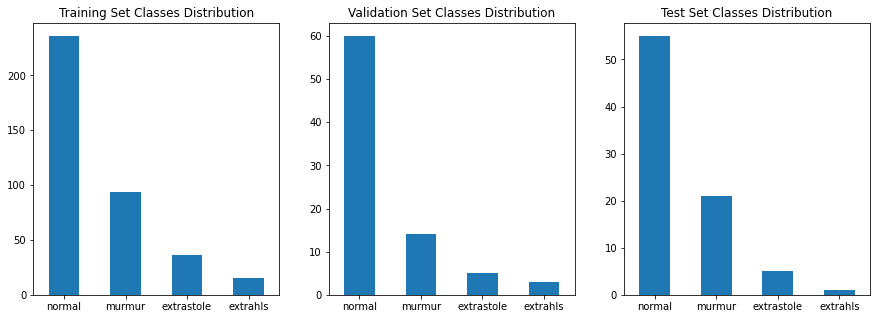

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1, 3)
train_class_data.label.value_counts().plot(ax=ax[0], kind='bar',title='Training Set Classes Distribution')
val_class_data.label.value_counts().plot(ax=ax[1], kind='bar',title='Validation Set Classes Distribution')
test_class_data.label.value_counts().plot(ax=ax[2], kind='bar',title='Test Set Classes Distribution')

for single_ax in ax:
    single_ax.tick_params(axis='x',rotation=0)
plt.show()

The three splits are balanced.

### Audio Analysis:

Here, we check the maximum and average length of each wav file, once resampled to 22.05kHz. 

In [ ]:
from statistics import mean

def read_wav_sample(filename):
    wav, sr = torchaudio.load(filepath=filename)
    # wav = torchaudio.transforms.Resample(sr, 22050)(wav)
    # sr = 22050
    return wav, sr

data_train = pd.read_csv(base + 'train_class_data.csv', index_col=False)
datalist_train = list(data_train.itertuples(index=False, name=None))
data_val = pd.read_csv(base + 'val_class_data.csv', index_col=False)
datalist_val = list(data_val.itertuples(index=False, name=None))
data_test = pd.read_csv(base + 'test_class_data.csv', index_col=False)
datalist_test = list(data_test.itertuples(index=False, name=None))
shapes1 = []
shapes2 = []
shapes3 = []
for path, label in datalist_train:
    wav, sr = read_wav_sample(base + path)
    shapes1.append(wav.shape[1])
for path, label in datalist_val:
    wav, sr = read_wav_sample(base + path)
    shapes2.append(wav.shape[1])
for path, label in datalist_test:
    wav, sr = read_wav_sample(base + path)
    shapes3.append(wav.shape[1])
print("Max length of train set:", max(shapes1))
print("Max length of val set:", max(shapes2))
print("Max length of test set:", max(shapes3))
print("Avg length of train set:", mean(shapes1))
print("Avg length of val set:", mean(shapes2))
print("Avg length of test set:", mean(shapes3))

Max length of train set: 396900
Max length of val set: 396900
Max length of test set: 396900
Avg length of train set: 71223.41469816273
Avg length of val set: 71219.91463414633
Avg length of test set: 84385.62195121951


### DataLoader Creation:

Dataloader for both tasks will be the same. It receives three datasets (train, validation, testing) as well as a batch size.

In [ ]:
class HeartbeatDataloaders(DataLoader):
    def __init__(self, train_set = None, val_set=None, test_set=None, batch_size=4):
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set
        self.batch_size = batch_size
        self.define_loaders()

    def define_loaders(self):
        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, \
                                       shuffle=True, num_workers=4)
        self.val_loader = DataLoader(self.val_set, batch_size=self.batch_size, \
                                     shuffle=False, num_workers=4)
        self.test_loader = DataLoader(self.test_set, batch_size=self.batch_size, \
                                     shuffle=False, num_workers=4)
    def get_train_loader(self):
        return self.train_loader

    def get_val_loader(self):
        return self.val_loader

    def get_test_loader(self):
        return self.test_loader   

## Task A: Building a Segmentation Model using 1D Convolutions and Two Regression Heads

The task is to produce a method that can locate S1 (lub) and S2 (dub) sounds within audio data, in normal heartbeat audio files.

### A. 1. Dataset Creation:

First, we create our Dataset class.

--> Both input and output should be wav files.

--> We added a Mel spectrogram and an MFCC to our dataset if we want our model to handle 2D data instead of 1D data.

**Steps:**

* We extract audio features as a spectrogram (time as x-axis, frequency as y axis). A spectrogram shows frequencies in linear scale.

* We convert to Mel Spectrogram which shows frequencis in Mel scale, since humans discriminate lower frequencies better than higher frequencies. (This is done using Mel filters).

* We transform amplitude into the decibel scale, since humans perceive loudness on a logarithmic scale.


**During loading of data:**

* We normalize the data so that the sample values are between -1.0 and +1.0.

* We convert stereo (two channels) to mono (on channel)

* We normalize label values to be between 0 and 1 depending on clip length.



In [ ]:
class HeartbeatDatasetSeg(Dataset):
    def __init__(self, csv_file, length=100000, sr_desired=44100, 
                 n_fft=1024, n_bins=128, resample=False, denoise=False, pad_and_cut=True):
        self.csv_file = csv_file
        self.length = length
        self.sr_desired = sr_desired
        self.denoise = denoise
        self.n_fft = n_fft
        self.n_bins = n_bins
        self.samples = []
        self.resample = resample
        self.pad_and_cut = pad_and_cut
        self.get_final_samples()

    def __getitem__(self, idx):
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)

    def parse_csv(self):
        data = pd.read_csv(base + self.csv_file, index_col=False)
        return list(data.itertuples(index=False, name=None))

    def get_final_samples(self):
        for path, label_s1, label_s2 in self.parse_csv():
            wav, sr = self.read_wav_sample(base + path)
            spectrogram = self.get_spectrogram(wav)
            mel_spec_db = self.get_mel_spectrogram_db(sr, wav)
            mfcc = self.get_mfcc(sr, wav)
            label_s1 = label_s1 / self.length
            label_s2 = label_s2 / self.length
            sample = {'wav': wav, 'spec': spectrogram, 'mel_spec_db': mel_spec_db, 'mfcc': mfcc,'label_s1': label_s1, 'label_s2': label_s2}
            self.samples.append(sample)

    def read_wav_sample(self, filename):
        wav, sr = torchaudio.load(filepath=filename)
        # resample if necessary so that sample rate is fixed
        if sr != self.sr_desired and self.resample == True:
            wav = torchaudio.transforms.Resample(sr, self.sr_desired)(wav)
            sr = self.sr_desired
        # normalize so that values are between -1.0 and +1.0
        rescaled = (wav - torch.min(wav)) / ( torch.max(wav) - torch.min(wav) )
        wav = 2 * rescaled - 1
        # padding so that all waveforms have same shape and cutting if necessary
        if self.pad_and_cut:
            if wav.shape[1] < self.length:
                missing_samples = self.length - wav.shape[1]
                padding = (0, missing_samples)
                wav = torch.nn.functional.pad(wav, padding)
            # here, we don't need to cut, so the following two lines are commented
            # this is to prevent from cutting a lub or a dub
            # if wav.shape[1] > self.length:
            #     wav = wav[:, :self.length]
        if self.denoise:
            wav_denoise = denoise_wavelet(wav.numpy(), method='BayesShrink', 
                    mode='soft', wavelet_levels=3, 
                    wavelet='sym8', rescale_sigma='True')
            wav_denoise = torch.from_numpy(wav_denoise)
            wav = wav_denoise

        return wav, sr

    def get_spectrogram(self, wav):
        return torchaudio.transforms.Spectrogram(n_fft=self.n_fft)(wav)

    def get_mel_spectrogram_db(self, sr, wav):
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=self.n_fft, n_mels=self.n_bins)(wav)
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        return mel_spec_db

    def get_mfcc(self, sr, wav):
        mfcc = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=self.n_bins, melkwargs={"n_fft": self.n_fft, "n_mels": self.n_bins})(wav)
        return mfcc

**Notes:**

* Height of Mel Spectrogram depends on number of bins

* Width of Mel Spectrogram depends on  $ ceil({length \times 2 \over n\_fft}) $

In [ ]:
dataset_hyperparams_seg = {"n_fft": 1024, "sr": 44100, "resample": False}

In [ ]:
n_fft = dataset_hyperparams_seg["n_fft"]
length =  max_clip_length
height = int(length*2/n_fft) + 1
sr = dataset_hyperparams_seg["sr"] 
resample = dataset_hyperparams_seg["resample"]
train_set_seg = HeartbeatDatasetSeg('train_seg_data.csv', length=length, sr_desired=sr, n_fft=n_fft, n_bins=height, resample=resample)
val_set_seg = HeartbeatDatasetSeg('val_seg_data.csv', length=length, sr_desired=sr, n_fft=n_fft, n_bins=height, resample=resample)
test_set_seg = HeartbeatDatasetSeg('test_seg_data.csv', length=length, sr_desired=sr, n_fft=n_fft, n_bins=height, resample=resample)

print("Max_clip_length:", max_clip_length)

Max_clip_length: 57766


### A. 2. Model Creation:

#### Custom Model 1 (OurSegModel)

Here, we define a custom model built from 1D Convolutions and having two regression heads.

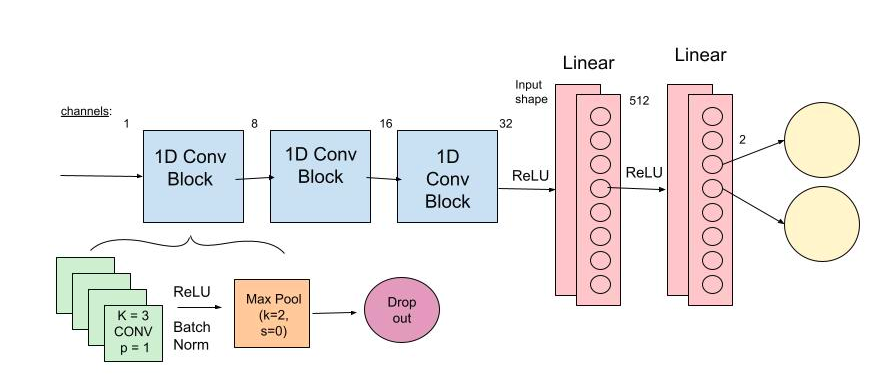

In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

class OurSegModel(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        # input will be 1D wav file and output will be two predictions
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=8,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=8,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        # here, output of linear layer should be number of classes to classify --> 2
        # we calculate first input size of linear layer
        n_size = self._get_conv_output(self.input_shape)
        self.linear_1 = nn.Linear(n_size, 512)
        self.linear_2 = nn.Linear(512, 2)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        logits = self.linear_2(x)
        # x = self.relu(x)
        # logits = self.linear_3(x)
        return logits


    def _get_conv_output(self, shape):
        bs = 1
        input_data = Variable(torch.rand(bs, *shape))
        x = self.conv1(input_data)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.flatten(x)
        n_size = x.data.view(bs, -1).size(1)
        return n_size

#### Custom Model 2: OurSegModel_2

The following model is a pure MLP architecture.

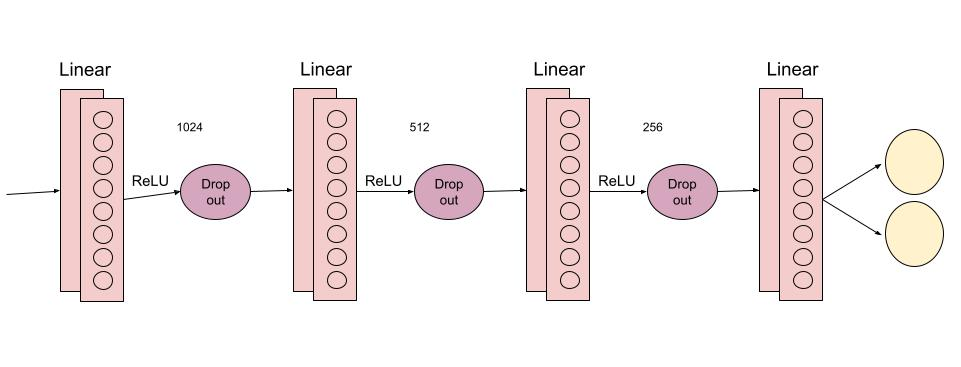

In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

class OurSegModel_2(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        # input will be 1D wav file and output will be two predictions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        # here, output of all linear layers should be number of classes to classify --> 2
        # we calculate first input size of linear layer
        self.linear_1 = nn.Linear(self.input_shape[1], 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 256)
        self.linear_4 = nn.Linear(256, 2)

    def forward(self, input_data):
        x = self.linear_1(input_data)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.linear_4(x)
        # x = self.relu(x)
        # logits = self.linear_3(x)
        return logits

### A. 3. Model Training and Testing

In [ ]:
class SegmentationModel(pl.LightningModule):
    
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, model=None, lr=0.001):
        super().__init__()
        self.model = model
        self.lr = lr
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        self.loss_fn = nn.MSELoss(reduction='mean')
        

    def forward(self, audio):
        outputs = self.model(audio)
        return outputs
        

    def training_step(self, batch, batch_idx):
        label_s1 = batch["label_s1"].unsqueeze(1).float()
        label_s2 = batch["label_s1"].unsqueeze(1).float()
        labels = torch.cat((label_s1, label_s2), 1)
        audio = batch["wav"].float()
        outputs = self(audio)
        loss = self.loss_fn(outputs, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True)     
        return loss
    
    # def training_epoch_end(self, outputs):
    #     pass
        
    def validation_step(self, batch, batch_idx):
        label_s1 = batch["label_s1"].unsqueeze(1).float()
        label_s2 = batch["label_s1"].unsqueeze(1).float()
        labels = torch.cat((label_s1, label_s2), 1)
        audio = batch["wav"].float()
        outputs = self(audio)
        loss = self.loss_fn(outputs, labels)

        metrics = {'val_loss': loss}
        for k,v in metrics.items():
            self.log(k,v, on_step=True, on_epoch=True)       
        return(metrics)
    
    # def validation_epoch_end(self, outputs):
    #     pass


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl


In [ ]:
def test_validate_seg(model, test_loader, batch_size):
    data = next(iter(test_loader))
    audio = data['wav']
    label_s1 = data["label_s1"].unsqueeze(1).float()
    label_s2 = data["label_s1"].unsqueeze(1).float()
    labels = torch.cat((label_s1, label_s2), 1)
    labels = labels.detach().cpu().numpy()
    
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(audio).detach().cpu().numpy()

    if outputs.ndim > 2:
        outputs = np.squeeze(outputs, 1)
    
    error = mean_squared_error(labels, outputs)
    print("MSE: ", error)

In [ ]:
import os
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger
from comet_ml import Experiment


def main_seg(hyperparams, model_name='OurSegModel'):

    # DataLoader
    loader = HeartbeatDataloaders(train_set_seg, val_set_seg, test_set_seg, batch_size = hyperparams["batch_size"])
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()
    test_loader = loader.get_test_loader()

    input_shape = next(iter(train_loader))['wav'][1].shape


    n_epochs = hyperparams["n_epochs"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    string = hyperparams["string"]

    os.makedirs(base + "checkpoints", exist_ok=True)

    exp_name = f"{model_name}_colab_{n_epochs}epochs_b{batch_size}_lr{lr}_{string}"
    
    checkpoint_1 = ModelCheckpoint(dirpath=base + f"checkpoints/{exp_name}", filename='{epoch}_{step}_{val_loss:.5f}', \
                                          save_top_k=5, monitor="val_loss", mode="min")
    checkpoint_2 = ModelCheckpoint(dirpath=base + f"checkpoints/{exp_name}", filename='{epoch}_{step}_{val_loss_epoch:.5f}', \
                                          save_top_k=5, monitor="val_loss_epoch", mode="min")

    comet_logger = CometLogger(
        api_key="aeMY8tfwoN3PJFejHzxLryDa3",
        project_name="heartbeat-sounds",
        workspace="nour-hesham",
        experiment_name=exp_name 
    )
    
    trainer = pl.Trainer(logger=comet_logger,
                         #accelerator="cpu", 
                         devices=1, 
                         callbacks=[checkpoint_1, checkpoint_2], 
                         max_epochs=hyperparams["n_epochs"],
                         log_every_n_steps=4
                         )
    
    params1 = hyperparams
    params2 = dataset_hyperparams_seg

    comet_logger.log_hyperparams(params1)
    comet_logger.log_hyperparams(params2)

    if model_name == 'OurSegModel': 
        initial_model = OurSegModel(input_shape)
    elif model_name == 'OurSegModel_2':
        initial_model = OurSegModel_2(input_shape)
    else:
        initial_model = None
        exit(1)

    model = SegmentationModel(train_loader, val_loader, test_loader, initial_model, lr=lr)
    
    trainer.fit(model)

In [ ]:
hyperparams_seg = {"lr": 0.005, "n_epochs": 50, "batch_size": 12, "optim": "Adam", "string":"begin"}

In [ ]:
import gc

gc.collect()

1648

In [ ]:
main_seg(hyperparams_seg, "OurSegModel_2")

### A. 4. Comparing Results

In [ ]:
def compare_seg(ckpt, model_name, batch_size):
    # DataLoader
    loader = HeartbeatDataloaders(train_set_seg, val_set_seg, test_set_seg, batch_size = batch_size)
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()
    test_loader = loader.get_test_loader()

    input_shape = next(iter(train_loader))['wav'][1].shape
    if model_name == 'OurSegModel':
        initial_model = OurSegModel(input_shape)
    elif model_name == 'OurSegModel_2':
        initial_model = OurSegModel_2(input_shape)

    ckpt_path = base + 'checkpoints/' + ckpt
    model = SegmentationModel(train_loader, val_loader, test_loader, model=initial_model, lr=0.001)
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("---- VAL SCORES ----")
    test_validate_seg(model, val_loader, batch_size)
    print("--------------------")
    print("---- TEST SCORES ----")    
    test_validate_seg(model, test_loader, batch_size)
    print("--------------------")

#### OurSegModel, LR = 0.0005, Batch_size = 10

In [ ]:
ckpt = 'OurSegModel_colab_20epochs_b10_lr0.0005_begin/epoch=17_step=252_val_loss=0.01302.ckpt'
batch_size = 10
compare_seg(ckpt, 'OurSegModel', batch_size)

---- VAL SCORES ----
MSE:  0.016704319
--------------------
---- TEST SCORES ----
MSE:  0.031899877
--------------------


#### OurSegModel, LR = 0.001, Batch_size = 12

In [ ]:
ckpt = 'OurSegModel_colab_20epochs_b12_lr0.001_begin/epoch=6_step=84_val_loss=0.01521.ckpt'
batch_size = 10
compare_seg(ckpt, 'OurSegModel', batch_size)

---- VAL SCORES ----
MSE:  0.020636456
--------------------
---- TEST SCORES ----
MSE:  0.038632274
--------------------


#### OurSegModel_2, LR = 0.001, Batch-size=8

In [ ]:
ckpt = 'OurSegModel_2_colab_20epochs_b8_lr0.001_begin/epoch=5_step=102_val_loss_epoch=0.01358.ckpt'
batch_size = 8
compare_seg(ckpt, 'OurSegModel_2', batch_size)

---- VAL SCORES ----
MSE:  0.018599087
--------------------
---- TEST SCORES ----
MSE:  0.03849349
--------------------


#### OurSegModel_2, LR = 0.005, Batch_size = 12

In [ ]:
ckpt = 'OurSegModel_2_colab_50epochs_b12_lr0.005_begin/epoch=47_step=576_val_loss=0.01026.ckpt'
batch_size = 12
compare_seg(ckpt, 'OurSegModel_2', batch_size)

---- VAL SCORES ----
MSE:  0.016725993
--------------------
---- TEST SCORES ----
MSE:  0.025610104
--------------------


## Task B: Building a Classification Model using a Convolutional Neural Network (CNN)

The task is to produce a method that can classify real heart audio (also known as “beat classification”) into one of four categories: Normal, Murmur, Extrasystole, Extrahls.

### B. 1. Dataset Creation:


First, we create our Dataset class.

--> Input should be wav file

--> Output should Mel_Spectrogram_DB or an MFCC

**Steps:**

* We extract audio features as a spectrogram (time as x-axis, frequency as y axis). A spectrogram shows frequencies in linear scale.

* We convert to Mel Spectrogram which shows frequencis in Mel scale, since humans discriminate lower frequencies better than higher frequencies. (This is done using Mel filters).

* We transform amplitude into the decibel scale, since humans perceive loudness on a logarithmic scale.


**During loading of data:**


* We resample wav audio to a fixed sample rate equal to 22.05KHz (like Librosa).

* We normalize the data so that the sample values are between -1.0 and +1.0.

* We convert stereo (two channels) to mono (on channel)



In [ ]:
# label mapping
label_map = {'normal': 0, 'murmur': 1, 'extrastole': 2, 'extrahls': 3}

In [ ]:
class HeartbeatDatasetClass(Dataset):
    def __init__(self, csv_file, length=500000, sr_desired=22050, n_fft=1024, n_bins=128, resample=False, denoise=False):
        self.csv_file = csv_file
        self.length = length
        self.sr_desired = sr_desired
        self.n_fft = n_fft
        self.n_bins = n_bins
        self.samples = []
        self.resample = resample
        self.denoise = denoise
        self.get_final_samples()

    def __getitem__(self, idx):
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)

    def parse_csv(self):
        data = pd.read_csv(base + self.csv_file, index_col=False)
        return list(data.itertuples(index=False, name=None))

    def get_final_samples(self):
        for path, label in self.parse_csv():
            wav, sr = self.read_wav_sample(base + path)
            spectrogram = self.get_spectrogram(wav)
            mel_spec_db = self.get_mel_spectrogram_db(sr, wav)
            mfcc = self.get_mfcc(sr, wav)
            sample = {'spec': spectrogram, 'mel_spec_db': mel_spec_db, 'mfcc': mfcc, 'label': np.array([label_map[label]])}
            self.samples.append(sample)

    def read_wav_sample(self, filename):
        wav, sr = torchaudio.load(filepath=filename)
        # print(wav.shape)
        # resample if necessary so that sample rate is fixed
        if sr != self.sr_desired and self.resample == True:
            wav = torchaudio.transforms.Resample(sr, self.sr_desired)(wav)
            sr = self.sr_desired
        # normalize so that values are between -1.0 and +1.0
        rescaled = (wav - torch.min(wav)) / ( torch.max(wav) - torch.min(wav) )
        wav = 2 * rescaled - 1
        # padding so that all waveforms have same shape
        if wav.shape[1] < self.length:
            missing_samples = self.length - wav.shape[1]
            padding = (0, missing_samples)
            wav = torch.nn.functional.pad(wav, padding)
        # cutting if necessary 
        if wav.shape[1] > self.length:
            wav = wav[:, :self.length]
        if self.denoise:
            wav_denoise = denoise_wavelet(wav.numpy(), method='BayesShrink', 
                    mode='soft', wavelet_levels=3, 
                    wavelet='sym8', rescale_sigma='True')
            wav_denoise = torch.from_numpy(wav_denoise)
            wav = wav_denoise
        return wav, sr

    def get_spectrogram(self, wav):
        return torchaudio.transforms.Spectrogram(n_fft=self.n_fft)(wav)

    def get_mel_spectrogram_db(self, sr, wav):
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=self.n_fft, n_mels=self.n_bins)(wav)
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        return mel_spec_db

    def get_mfcc(self, sr, wav):
        mfcc = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=self.n_bins, melkwargs={"n_fft": self.n_fft, "n_mels": self.n_bins})(wav)
        return mfcc

**Notes:**

* Height of Mel Spectrogram depends on number of bins

* Width of Mel Spectrogram depends on  $ ceil({length \times 2 \over n\_fft}) $

* We can conclude, that if we want our sample to be a certain width, we find length by the following equation: $length = floor({height \times n\_fft \over 2}) $

In [ ]:
dataset_hyperparams_class = {"n_fft": 1024, "height": 40, "sr": 22050, "resample": False}

In [ ]:
n_fft = dataset_hyperparams_class["n_fft"]
height = dataset_hyperparams_class["height"] # we determine height to be 64
length =  int(height * n_fft / 2) - 1
# length = 396900
sr = dataset_hyperparams_class["sr"] # like librosa
resample = dataset_hyperparams_class["resample"]
train_set_class = HeartbeatDatasetClass('train_class_data.csv', length=length, sr_desired=sr, n_fft=n_fft, n_bins=height, resample=resample)
val_set_class = HeartbeatDatasetClass('val_class_data.csv', length=length, sr_desired=sr, n_fft=n_fft, n_bins=height, resample=resample)
test_set_class = HeartbeatDatasetClass('test_class_data.csv', length=length, sr_desired=sr, n_fft=n_fft, n_bins=height, resample=resample)

torch.Size([1, 40, 40])


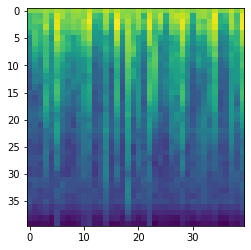

In [ ]:
item = val_set_class[26]
mel = item['mel_spec_db']
print(mel.shape)
plt.imshow(mel.squeeze(0))
plt.show()

torch.Size([1, 40, 40])


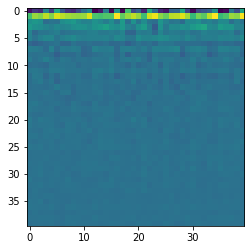

In [ ]:
item = val_set[26]
mel = item["mfcc"]
print(mel.shape)
plt.imshow(mel.squeeze(0))
plt.show()

### B. 2. Model Definition: 


#### Custom Model 1 (OurCNN)

Here, we define a custom model built from 4 convolutional blocks followed by a linear layer (after flattening) then a softmax layer to compute predictions.

Each convolutional block consists of a (5x5) CONV layer, a ReLU activation function, and a max pooling layer with a kernel size of 2 (halving).

After each Conv Block there is a dropout layer for regularization to prevent overfitting.

Hidden channels of the model start as:

1x16 -> 16x32 -> 32x64 -> 64x128


Input to this model is either a Mel Spectrogram or an MFCC. 


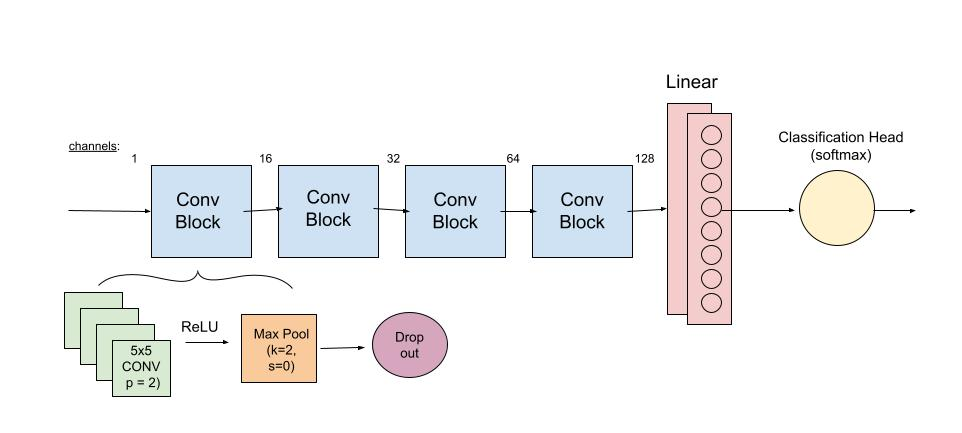

In [ ]:
class OurCNN(nn.Module):

    def __init__(self, num_classes):
        self.num_classes = num_classes
        super().__init__()
        # 4 conv blocks --> flatten --> linear 
        # A conv block is made up of a conv layer, a ReLU activation, and a MaxPool2D
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        # here, output of linear layer should be number of classes to classify
        self.linear = nn.Linear(128 * 2 * 2, self.num_classes)  
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        #predictions = self.softmax(logits)
        #return predictions
        return logits

#### Alternative architecture: OurCNN_2

Here, we complicate our architecture a little bit.

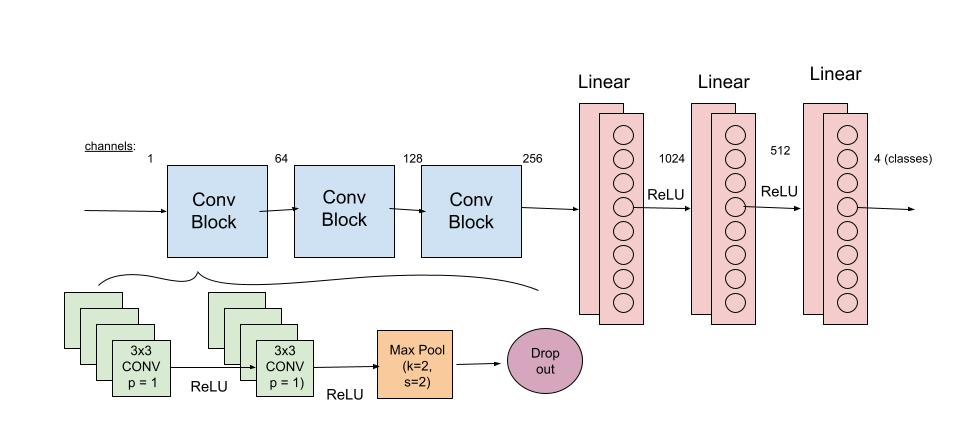

In [ ]:
class OurCNN_2(nn.Module):

    def __init__(self, num_classes):
        self.num_classes = num_classes
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.relu = nn.ReLU() 
        self.flatten = nn.Flatten()
        # here, output of linear layer should be number of classes to classify
        self.linear_1 = nn.Linear(256 * 5 * 5, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, self.num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        logits = self.linear_3(x)
        #predictions = self.softmax(logits)
        #return predictions
        return logits

#### Pre-trained ResNet

The following model is a pre-trained ResNet34 model. We change the first conv layer of ResNet34 that accepts 3 channels (RGB) so that it can accept only one channel.

As well, we change the final fully connected layer that outputs 1000 categories, into a simpler 4-category classification head.

Outputs of this model are **logits** and not predictions, since there isn't a final softmax layer.

In [ ]:
from torchvision.models import resnet34

resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,4)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# resnet_model = resnet_model.to(device)
#resnet_model


In [ ]:
from torchvision.models import resnet50

resnet_model = resnet50(pretrained=True)
resnet_model.fc = nn.Linear(2048,4)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### B. 3. Model Training & Testing

In [ ]:
class ClassificationModel(pl.LightningModule):
    
    def __init__(self, data_type="mffc", train_dataloader=None, val_dataloader=None, test_dataloader=None, model=None, lr=0.001, average='micro'):
        super().__init__()
        self.model = model
        self.data_type = data_type
        self.lr = lr
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        self.loss_fn = nn.CrossEntropyLoss()
        self.average = average
        self.train_accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=4, average=self.average)
        self.val_accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=4, average=self.average)
        self.train_f1_fn = torchmetrics.F1Score(task="multiclass", num_classes=4, average=self.average)
        self.val_f1_fn = torchmetrics.F1Score(task="multiclass", num_classes=4, average=self.average)

    def forward(self, image):
        outputs = self.model(image)
        return outputs
        

    def training_step(self, batch, batch_idx):
        labels = batch["label"]
        labels = torch.squeeze(labels, dim=1)
        if self.data_type == "mfcc":
            images = batch['mfcc']
        else:
            images = batch["mel_spec_db"]
        outputs = self(images)

        loss = self.loss_fn(outputs, labels)
        ## SOFTMAX
        outputs = F.softmax(outputs, dim=1)
        ##
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = torch.squeeze(preds, dim=1)
        self.train_accuracy_fn.update(preds, labels)
        self.train_f1_fn.update(preds, labels)

        sklearn_acc = accuracy_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy())
        sklearn_prec = precision_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_recall = recall_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_f1 = f1_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average)
        metrics = {'loss': loss, 'train_sklearn_acc': sklearn_acc, 'train_sklearn_prec': sklearn_prec, \
                   'train_sklearn_recall': sklearn_recall, 'train_sklearn_f1': sklearn_f1}   

        for k,v in metrics.items():
            self.log(k,v, on_step=True, on_epoch=True)       
        return(metrics)
    
    def training_epoch_end(self, outputs):
        self.log('train_acc_epoch', self.train_accuracy_fn.compute())
        self.log('train_f1_epoch', self.train_f1_fn.compute())
        self.train_accuracy_fn.reset()
    
    def validation_step(self, batch, batch_idx):
        labels = batch["label"]
        labels = torch.squeeze(labels, dim=1)
        if self.data_type == "mfcc":
            images = batch['mfcc']
        else:
            images = batch["mel_spec_db"]
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        ## SOFTMAX
        outputs = F.softmax(outputs, dim=1)
        ##
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = torch.squeeze(preds, dim=1)
        self.val_accuracy_fn.update(preds, labels)
        self.val_f1_fn.update(preds, labels)


        sklearn_acc = accuracy_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy())
        sklearn_prec = precision_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_recall = recall_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_f1 = f1_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average)
        metrics = {'val_loss': loss, 'val_sklearn_acc': sklearn_acc, 'val_sklearn_prec': sklearn_prec, \
                   'val_sklearn_recall': sklearn_recall, 'val_sklearn_f1': sklearn_f1}   
                     
        for k,v in metrics.items():
            self.log(k,v, on_step=True, on_epoch=True)       
        return(metrics)
    
    def validation_epoch_end(self, outputs):
        self.log('val_acc_epoch', self.val_accuracy_fn.compute())
        self.log('val_f1_epoch', self.val_f1_fn.compute())
        self.val_accuracy_fn.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl


In [ ]:
def test_validate_class(model, test_loader, batch_size, data_type):
    # get batch of images from the test DataLoader  
    data = next(iter(test_loader))
    if data_type == 'mfcc':
        imgs = data['mfcc']
    else:
        imgs = data['mel_spec_db']
    labels = data['label'].detach().cpu().numpy()
    

    # Let's see what if the model identifiers the  labels of those example
    outputs = model(imgs)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    preds = torch.argmax(outputs, 1).detach().cpu().numpy()
    
    # confusion matrix
    matrix = confusion_matrix(labels, preds)
    print(matrix)
   
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(labels, preds)
    print('Accuracy: %f' % accuracy)
    acc = np.sum(matrix.diagonal()) / np.sum(matrix)
    print('Overall accuracy: {} %'.format(acc*100))
    
    # precision tp / (tp + fp)
    precision = precision_score(labels, preds, average='weighted', zero_division = 1)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(labels, preds, average='weighted', zero_division = 1)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(labels, preds, average='weighted', zero_division = 1)
    print('F1 score: %f' % f1)
    

In [ ]:
import os
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger
from comet_ml import Experiment


def main_class(hyperparams, model_name='OurCNN'):

    # DataLoader
    loader = HeartbeatDataloaders(train_set_class, val_set_class, test_set_class, batch_size = hyperparams["batch_size"])
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()
    test_loader = loader.get_test_loader()

    n_epochs = hyperparams["n_epochs"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    data_type = hyperparams["data_type"]
    average = hyperparams["average"]
    string = hyperparams["string"]

    os.makedirs(base + "checkpoints", exist_ok=True)

    exp_name = f"{model_name}_colab_{n_epochs}epochs_b{batch_size}_lr{lr}_{data_type}_{average}{string}"
    
    checkpoint_accuracy = ModelCheckpoint(dirpath=base + f"checkpoints/{exp_name}", filename='{epoch}_{step}_{val_acc_epoch:.5f}', \
                                          save_top_k=5, monitor="val_acc_epoch", mode="max")

    checkpoint_f1 = ModelCheckpoint(dirpath=base+ f"checkpoints/{exp_name}", filename='{epoch}_{step}_{val_f1_epoch:.5f}', \
                                          save_top_k=5, monitor="val_f1_epoch", mode="max")
    comet_logger = CometLogger(
        api_key="aeMY8tfwoN3PJFejHzxLryDa3",
        project_name="heartbeat-sounds",
        workspace="nour-hesham",
        experiment_name=exp_name 
    )
    
    trainer = pl.Trainer(logger=comet_logger,
                         # accelerator="cpu", 
                         devices=1, 
                         callbacks=[checkpoint_accuracy, checkpoint_f1], 
                         max_epochs=hyperparams["n_epochs"],
                         log_every_n_steps=4
                         )
    
    params1 = hyperparams
    params2 = dataset_hyperparams_class

    comet_logger.log_hyperparams(params1)
    comet_logger.log_hyperparams(params2)

    if model_name == 'resnet50' or model_name == 'Resnet50':
        initial_model = resnet50(pretrained=False)
        initial_model.fc = nn.Linear(2048,4)
        initial_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif model_name == 'OurCNN': 
        initial_model = OurCNN(num_classes=4)
    elif model_name == 'OurCNN_2':
        initial_model = OurCNN_2(num_classes=4)
    elif model_name == 'resnet34' or model_name == 'Resnet34':
        initial_model = resnet34(pretrained=False)
        initial_model.fc = nn.Linear(512, 4)
        initial_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    else:
        initial_model = None
        exit(1)

    model = ClassificationModel(data_type, train_loader, val_loader, test_loader, initial_model, lr=lr, average=hyperparams['average'])
    
    trainer.fit(model)

In [ ]:
hyperparams_class = {"lr": 0.0005, "n_epochs": 300, "batch_size": 64, "optim": "Adam", "data_type": "mel", "average":'weighted', "string":"_softmax_batchnorm_retrain"}

In [ ]:
main_class(hyperparams_class, 'resnet34')

### B. 4. Comparing Results

Here, we load our best checkpoints and compare validation and testing results:

In [ ]:
def compare_class(ckpt, model_name, batch_size, data_type, average):
    if model_name == 'OurCNN': 
        initial_model = OurCNN(num_classes=4)
    elif model_name == 'OurCNN_2':
        initial_model = OurCNN_2(num_classes=4)
    elif model_name == 'Resnet':
        initial_model = resnet34(pretrained=False)
        initial_model.fc = nn.Linear(512, 4)
        initial_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    else:
        initial_model = None
    # DataLoader
    loader = HeartbeatDataloaders(train_set_class, val_set_class, test_set_class, batch_size=batch_size)
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()
    test_loader = loader.get_test_loader()
    ckpt_path = base + 'checkpoints/' + ckpt
    model = ClassificationModel(data_type, train_loader, val_loader, test_loader, model=initial_model, lr=0.001, average=average)
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("---- VAL SCORES ----")
    test_validate_class(model, val_loader, batch_size, data_type)
    print("--------------------")
    print("---- TEST SCORES ----")    
    test_validate_class(model, test_loader, batch_size, data_type)
    print("--------------------")

#### OurCNN, LR = 0.0005, BS = 64, Data = Mel



In [ ]:
ckpt = 'OurCNN_colab_650epochs_b64_lr0.0005_mel_weighted_softmax_batchnorm_retrain/epoch=53_step=324_val_acc_epoch=0.79268.ckpt'
batch_size = 64
data_type = "mel"
average = "weighted"
compare_class(ckpt, 'OurCNN', batch_size, data_type, average)

---- VAL SCORES ----
[[46  1  0  4]
 [ 1  4  0  2]
 [ 3  0  0  0]
 [ 0  0  0  3]]
Accuracy: 0.828125
Overall accuracy: 82.8125 %
Precision: 0.883125
Recall: 0.828125
F1 score: 0.822221
--------------------
---- TEST SCORES ----
[[38  0  0  5]
 [ 6  8  0  2]
 [ 3  1  0  0]
 [ 0  0  0  1]]
Accuracy: 0.734375
Overall accuracy: 73.4375 %
Precision: 0.829893
Recall: 0.734375
F1 score: 0.730833
--------------------


#### Our CNN, LR = 0.001, BS = 64, Data = Mel

In [ ]:
ckpt = 'OurCNN_colab_450epochs_b64_lr0.001_mel_weighted_softmax_batchnorm_retrain/epoch=37_step=228_val_acc_epoch=0.80488.ckpt'
batch_size = 64
data_type = "mel"
average = "weighted"
compare_class(ckpt, 'OurCNN', batch_size, data_type, average)

---- VAL SCORES ----
[[47  0  0  4]
 [ 1  4  0  2]
 [ 3  0  0  0]
 [ 0  0  0  3]]
Accuracy: 0.843750
Overall accuracy: 84.375 %
Precision: 0.906250
Recall: 0.843750
F1 score: 0.837358
--------------------
---- TEST SCORES ----
[[40  0  0  3]
 [ 7  8  0  1]
 [ 3  1  0  0]
 [ 0  0  0  1]]
Accuracy: 0.765625
Overall accuracy: 76.5625 %
Precision: 0.825347
Recall: 0.765625
F1 score: 0.743165
--------------------


#### OurCNN_2, LR = 0.001, BS = 64, Data = Mel

In [ ]:
ckpt = 'OurCNN_2_colab_450epochs_b64_lr0.001_mel_weighted_softmax_batchnorm_retrain/epoch=271_step=1632_val_acc_epoch=0.81707.ckpt'
batch_size = 64
data_type = "mel"
average = "weighted"
compare_class(ckpt, 'OurCNN_2', batch_size, data_type, average)

---- VAL SCORES ----
[[45  2  3  1]
 [ 0  6  0  1]
 [ 3  0  0  0]
 [ 1  0  0  2]]
Accuracy: 0.828125
Overall accuracy: 82.8125 %
Precision: 0.837293
Recall: 0.828125
F1 score: 0.831473
--------------------
---- TEST SCORES ----
[[32  6  2  3]
 [ 3 11  1  1]
 [ 3  1  0  0]
 [ 0  0  0  1]]
Accuracy: 0.687500
Overall accuracy: 68.75 %
Precision: 0.721692
Recall: 0.687500
F1 score: 0.697837
--------------------


#### OurCNN_2, LR = 0.0005, BS = 64, Data = Mel

In [ ]:
ckpt = 'OurCNN_2_colab_300epochs_b64_lr0.0005_mel_weighted_softmax_batchnorm_retrain/epoch=26_step=162_val_acc_epoch=0.81707.ckpt'
batch_size = 64
data_type = "mel"
average = "weighted"
compare_class(ckpt, 'OurCNN_2', batch_size, data_type, average)

---- VAL SCORES ----
[[48  1  0  2]
 [ 1  4  0  2]
 [ 3  0  0  0]
 [ 0  0  0  3]]
Accuracy: 0.859375
Overall accuracy: 85.9375 %
Precision: 0.890041
Recall: 0.859375
F1 score: 0.843760
--------------------
---- TEST SCORES ----
[[40  1  0  2]
 [ 5 10  0  1]
 [ 4  0  0  0]
 [ 0  0  0  1]]
Accuracy: 0.796875
Overall accuracy: 79.6875 %
Precision: 0.842148
Recall: 0.796875
F1 score: 0.775674
--------------------


ResNet34, LR = 0.0005, BS = 64, Data = Mel

In [ ]:
ckpt = 'resnet34_colab_300epochs_b64_lr0.0005_mel_weighted_softmax_batchnorm_retrain/epoch=19_step=120_val_acc_epoch=0.78049.ckpt'
batch_size = 64
data_type = "mel"
average = "weighted"
compare_class(ckpt, 'Resnet', batch_size, data_type, average)

---- VAL SCORES ----
[[45  4  0  2]
 [ 1  4  1  1]
 [ 3  0  0  0]
 [ 0  0  0  3]]
Accuracy: 0.812500
Overall accuracy: 81.25 %
Precision: 0.809949
Recall: 0.812500
F1 score: 0.806771
--------------------
---- TEST SCORES ----
[[40  0  2  1]
 [ 7  8  0  1]
 [ 3  1  0  0]
 [ 1  0  0  0]]
Accuracy: 0.750000
Overall accuracy: 75.0 %
Precision: 0.749183
Recall: 0.750000
F1 score: 0.731809
--------------------
